In [24]:
pip uninstall imgaug

Uninstalling imgaug-0.2.9:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/imgaug-0.2.9.dist-info/*
    /usr/local/lib/python3.6/dist-packages/imgaug/*
Proceed (y/n)? y
  Successfully uninstalled imgaug-0.2.9


In [25]:
pip install git+https://github.com/aleju/imgaug.git

  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-px9ysxlu
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-px9ysxlu
  Created wheel for imgaug: filename=imgaug-0.4.0-cp36-none-any.whl size=958594 sha256=17c8d2dd388a227fe45c8c89ad8757eda1fba0e6fc1481b745691b1d87d88599
  Stored in directory: /tmp/pip-ephem-wheel-cache-3uyfnqf2/wheels/65/3d/94/ee32cbeaa29c473a4db74c2d21904ac747311fdca4732665f0
Successfully built imgaug
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.


In [0]:
import os
import time
import tqdm
import glob
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import skimage
from skimage.transform import resize

In [0]:
import imgaug.augmenters as iaa

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import tensorflow.keras.utils
import tensorflow.keras.backend as K

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ГЕНЕРАТОР

# Датасет

In [0]:
noise_shape = (1,1,100)
num_steps = 5000
batch_size = 32
img_save_dir = '/content/drive/My Drive/deep learn/smiles_result_2/'
#"/content/drive/My Drive/deep learn/anime_results/"
save_model = True
image_shape = (64,64) 
#'/content/drive/My Drive/deep learn/anime/*.png'
save_model_dir = img_save_dir

In [6]:
!ls '/content/drive/My Drive/deep learn/smiles'

10.png	14.png	18.png	21.png	25.png	29.png	32.png	6.png
11.png	15.png	19.png	22.png	26.png	2.png	3.png	7.png
12.png	16.png	1.png	23.png	27.png	30.png	4.png	8.png
13.png	17.png	20.png	24.png	28.png	31.png	5.png	9.png


In [0]:
import glob

In [0]:
from sklearn.utils import shuffle

In [0]:
images_path = glob.glob('/content/drive/My Drive/deep learn/smiles/*')

In [10]:
images = []
for i in tqdm.tqdm_notebook(images_path):
  images.append(resize(1-plt.imread(i)[:,:,0],(28,28,1)))
#images = np.array(images)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


## Аугментация

In [0]:
root_img = images[17]

In [0]:
root_img.shape

(28, 28, 1)

In [0]:
aug = iaa.Sequential([
                      iaa.Affine(scale=(1, 1.2)),
                      iaa.PiecewiseAffine(scale=(0.01, 0.03)),
                      iaa.PerspectiveTransform(scale=(0.01, 0.1)),
                      iaa.ElasticTransformation(alpha=(0, 5.0), sigma=4)
], random_order=True)

In [0]:
expand_images = []
for i in range(32):
  expand_images.append(root_img)

In [0]:
expand_images = np.array(expand_images)

In [0]:
aug_im = aug(images = images)

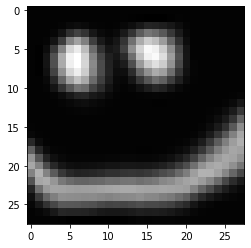

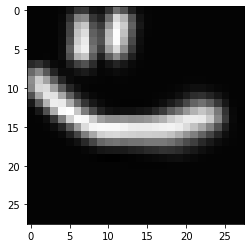

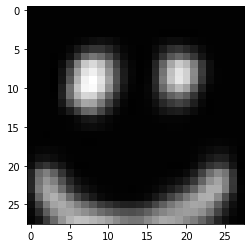

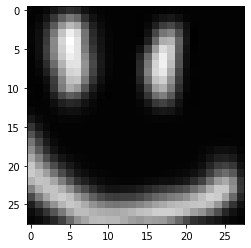

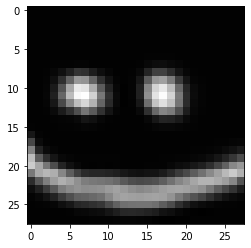

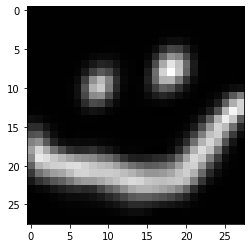

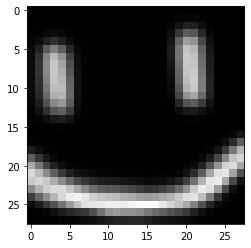

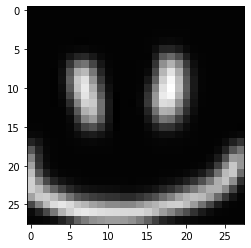

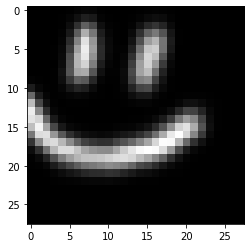

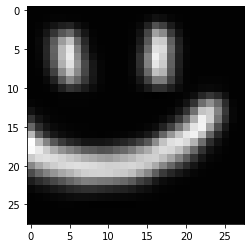

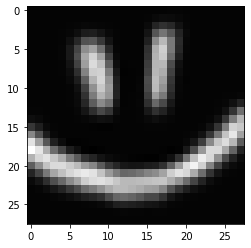

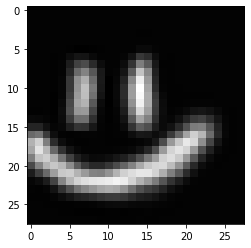

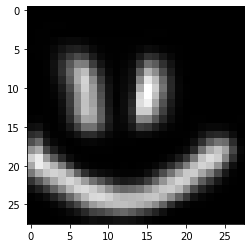

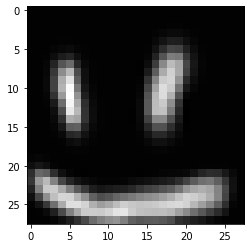

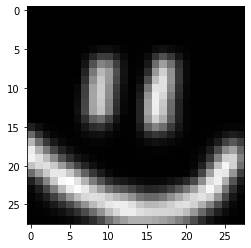

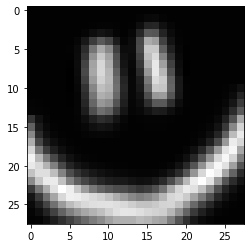

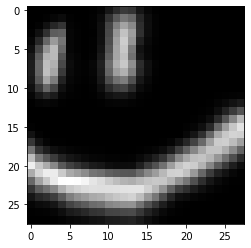

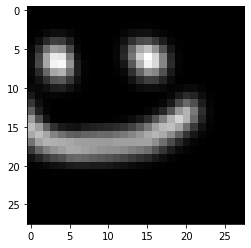

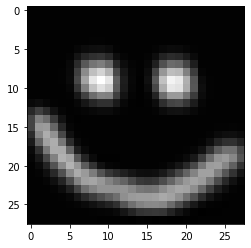

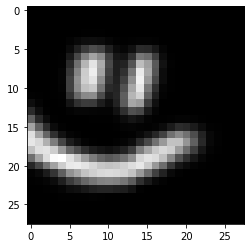

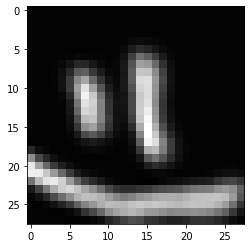

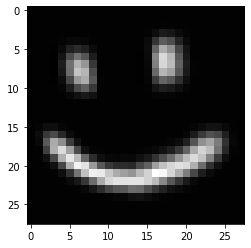

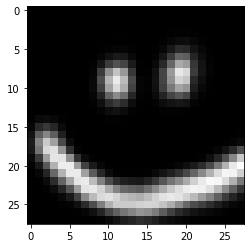

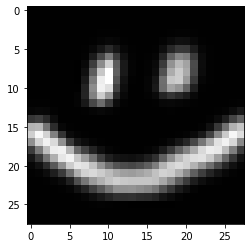

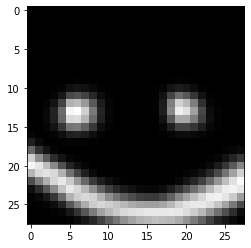

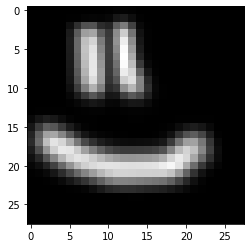

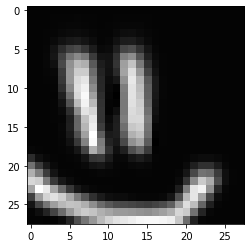

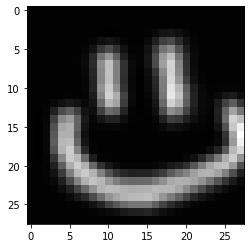

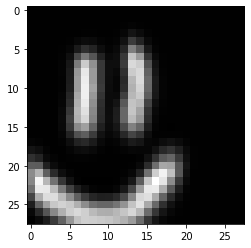

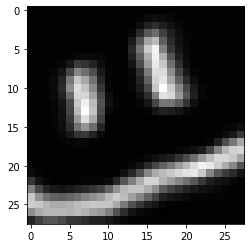

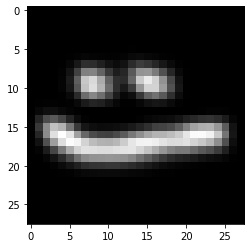

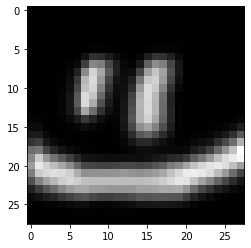

In [13]:
for im in aug_im:
  plt.imshow(im.squeeze(),'gray')
  plt.show()

In [0]:
train_images = shuffle(np.array(expand_images))

In [0]:
train_images.shape

(256, 28, 28, 1)

In [0]:
def get_batch(train, batch_size):
  train =(train - 0.5)/0.5  
  return train[np.random.choice(len(train),batch_size,replace=False)]

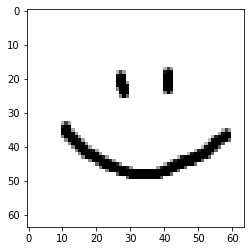

In [0]:
plt.imshow(get_batch(train_images,1).squeeze(), 'gray')

In [0]:
def gen_noise(batch_size, noise_shape):
    #input noise for the generator should follow a probability distribution, like in this case, the normal distributon.
    return np.random.normal(0, 1, size=(batch_size,)+noise_shape)

In [0]:
def generate_images(generator, save_dir):
    noise = gen_noise(batch_size,noise_shape)
    fake_data_X = generator.predict(noise)
    print("Displaying generated images")
    plt.figure(figsize=(4,4))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0, hspace=0)
    rand_indices = np.random.choice(fake_data_X.shape[0],16,replace=False)
    for i in range(16):
        #plt.subplot(4, 4, i+1)
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        rand_index = rand_indices[i]
        image = fake_data_X[rand_index, :,:,:]
        fig = plt.imshow(denorm_img(image))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig(save_dir+str(time.time())+"_GENimage.png",bbox_inches='tight',pad_inches=0)
    plt.show()

In [0]:
def save_img_batch(img_batch,img_save_dir):
    plt.figure(figsize=(4,4))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0, hspace=0)
    rand_indices = np.random.choice(img_batch.shape[0],16,replace=False)
    for i in range(16):
        #plt.subplot(4, 4, i+1)
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        image = img_batch[rand_indices[i], :,:,:].reshape(image_shape)
        fig = plt.imshow(image)
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig(img_save_dir,bbox_inches='tight',pad_inches=0)
    plt.show()   

# GAN

In [0]:
#for i in np.clip(aug(images = (np.array(images)-0.5)/0.5),-1,1):
  plt.imshow(i.squeeze())
  plt.show()

In [0]:
from __future__ import print_function, division

import sys


class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()   
        self.discriminator.summary() 
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        

        # Build the generator
        self.generator = self.build_generator()
        self.generator.summary()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid, name = 'gan')
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        generator = Model(noise, img, name = 'generator')
        generator.load_weights('/content/drive/My Drive/deep learn/smiles_result_2/1884_GENERATOR_weights_and_arch.hdf5')

        return generator

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(ReLU(negative_slope=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(ReLU(negative_slope=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(ReLU(negative_slope=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(ReLU(negative_slope=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        img = Input(shape=self.img_shape)
        validity = model(img)

        discriminator = Model(img, validity, name = 'discriminator')
        #discriminator.load_weights(save_model_dir+'4000_DISCRIMINATOR_weights_and_arch.hdf5')
        return discriminator

    def train(self, train_image, epochs, batch_size=200, save_interval=50):

        #train_image = (train_image - 0.5)/0.5
        train_images = (np.array(train_image)-0.5)/0.5
        #expand_images = []
        #for i in range(batch_size):
        #    expand_images.append(train_image)
        #train_images = np.array(expand_images)

        X_train = train_images
        print(np.clip(aug(images = X_train),-1,1).shape)
        

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        g_loss = 0
        for epoch in range(1884,epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            imgs = np.clip(aug(images = X_train),-1,1)
            a = 10 if epoch < 2500 else 2
            for i in range(a):
              # Sample noise and generate a batch of new images
              noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
              gen_imgs = self.generator.predict(noise)

              #train on all data
              sum_images = np.concatenate((imgs[:int(batch_size/2)],gen_imgs[:int(batch_size/2)]))
              sum_labels = np.concatenate((valid[:int(batch_size/2)], fake[:int(batch_size/2)]))
              sum_images, sum_labels = shuffle(sum_images, sum_labels)
              d_loss = self.discriminator.train_on_batch(sum_images, sum_labels)
              if  d_loss[1] > 0.7:
                break




            # Train the discriminator (real classified as ones and generated as zeros)
            #if epochs < 500:
            #d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            #d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)  
            #else:
            #for i in range(20):
              # Sample noise and generate a batch of new images
              #noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
              #gen_imgs = self.generator.predict(noise)
              #d_loss_real = self.discriminator.train_on_batch(imgs, valid) 
              #d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
              #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
              #if (d_loss[1] > 0.9) & (g_loss > 2):
                #break
              
            
            

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            a = 10 if epoch < 3000 else 20
            for i in range(a):
              noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
              g_loss = self.combined.train_on_batch(noise, valid)
              if g_loss < 0.7:
                break
            

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                self.generator.save(save_model_dir+str(epoch)+"_GENERATOR_weights_and_arch.hdf5")
                self.discriminator.save(save_model_dir+str(epoch)+"_DISCRIMINATOR_weights_and_arch.hdf5")

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(img_save_dir+"%d.png" % epoch)
        plt.close()

    def get_batch(train, batch_size):
        train =(train - 0.5)/0.5  
        return train[np.random.choice(len(train),batch_size,replace=False)]

In [19]:
dcgan = DCGAN()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 393729    
Total params: 393,729
Trainable params: 392,833
Non-trainable params: 896
_________________________________________________________________
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28, 1)         856193    
Total params: 856,193
Trainable params: 855,809
Non-trainable params: 384
_________________________________________________________________


In [20]:
dcgan.train(images, epochs=14000, batch_size=32, save_interval=500)

Streaming output truncated to the last 5000 lines.
9001 [D loss: 0.654685, acc.: 62.50%] [G loss: 0.679968]
9002 [D loss: 0.686822, acc.: 62.50%] [G loss: 0.741798]
9003 [D loss: 0.692965, acc.: 56.25%] [G loss: 0.699150]
9004 [D loss: 0.725432, acc.: 50.00%] [G loss: 0.666769]
9005 [D loss: 0.694916, acc.: 53.12%] [G loss: 0.680188]
9006 [D loss: 0.727010, acc.: 43.75%] [G loss: 0.696728]
9007 [D loss: 0.688459, acc.: 59.38%] [G loss: 0.642181]
9008 [D loss: 0.695566, acc.: 62.50%] [G loss: 0.681649]
9009 [D loss: 0.708135, acc.: 37.50%] [G loss: 0.649230]
9010 [D loss: 0.679593, acc.: 53.12%] [G loss: 0.699963]
9011 [D loss: 0.703216, acc.: 53.12%] [G loss: 0.678253]
9012 [D loss: 0.675467, acc.: 59.38%] [G loss: 0.655890]
9013 [D loss: 0.701433, acc.: 40.62%] [G loss: 0.674485]
9014 [D loss: 0.693406, acc.: 46.88%] [G loss: 0.662890]
9015 [D loss: 0.677486, acc.: 62.50%] [G loss: 0.673227]
9016 [D loss: 0.651129, acc.: 75.00%] [G loss: 0.692963]
9017 [D loss: 0.710113, acc.: 46.88%]

In [0]:
root_img[np.newaxis]

(1, 28, 28, 1)

In [0]:
#dcgan.generator.save(save_model_dir+str(13999)+"_GENERATOR_weights_and_arch.hdf5")

In [0]:
dcgan.discriminator.predict(dcgan.generator.predict(np.random.normal(0, 1, (1, 100))))

array([[0.78379095]], dtype=float32)

In [0]:
dcgan.discriminator.predict(root_img[np.newaxis])

array([[0.84431416]], dtype=float32)

In [0]:
dcgan.discriminator.predict(np.random.normal(-1, 1, (1, 28,28,1)))

array([[0.]], dtype=float32)

In [0]:
#dcgan.generator.load_weights(save_model_dir+'9000_GENERATOR_weights_and_arch.hdf5')

In [1]:
for i in range(30):
  plt.imshow(dcgan.generator.predict(np.random.normal(0, 1, (1, 100))).squeeze())
  plt.show()

NameError: ignored

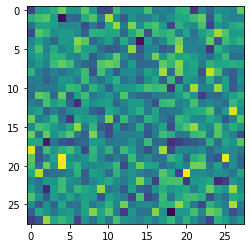

In [0]:
plt.imshow(np.random.normal(0, 1, (28,28)))

In [0]:
np.concatenate((np.ones((batch_size, 1))[:int(batch_size/2)],np.zeros((batch_size, 1))[:int(batch_size/2)])).shape

(32, 1)